In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [168]:
db_path = 'concerts.db'
conn = sqlite3.connect(db_path)

In [169]:
db_table_names = ('artist', 'customer', 'genre', 'performance', 'ticket', 'ticketpricing')
table_df_dict = dict()

for table_name in db_table_names:
    table_df_dict[table_name] = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)

In [170]:
df = pd.DataFrame()

In [171]:
def populate_with_data(df):
    df['Ticket Price'] = table_df_dict['ticket']['ticketPrice']
    df['Ticket Category'] = table_df_dict['ticket']['type']

    merged_df = pd.merge(table_df_dict['artist'], table_df_dict['genre'], on='idGenre', how='left')
    merged_df = pd.merge(table_df_dict['performance'], merged_df, on='idArtist', how='left')
    merged_df = pd.merge(table_df_dict['ticket'], merged_df, on='idPerformance', how='left')

    df['Artist'] = merged_df['name_x']
    df['Genre'] = merged_df['genreName']
    df['Performance Name'] = merged_df['name_y']
    df['Performance Date'] = merged_df['date']

    df['Official Ticket Price'] = table_df_dict['ticket'].merge(
        table_df_dict['ticketpricing'][['idPerformance', 'Type', 'price']],
        left_on=['idPerformance', 'type'],
        right_on=['idPerformance', 'Type'],
        how='left'
    )['price']

In [172]:
populate_with_data(df)
df = df.drop('Official Ticket Price', axis=1)

In [173]:
df.head()

,Ticket Price,Ticket Category,Artist,Genre,Performance Name,Performance Date
0,2000,A,ABX,Pop,ABBA,2025-06-18 20:30:00
1,900,C,Adelaire,Pop,Adele,2025-06-19 20:30:00
2,200,D,BamaBeats,Country,Alabama,2025-06-20 20:30:00
3,1000,B,ChillSync,Rock,Coldplay,2025-06-21 20:30:00
4,900,A,Distorto,Metal,Disturbed,2025-06-25 21:30:00


In [174]:
df['Month'] = df['Performance Date'].str[5:7].astype(int)
df['Day'] = df['Performance Date'].str[8:10].astype(int)
df['Hour'] = df['Performance Date'].str[11:13].astype(int)
df['Minute'] = df['Performance Date'].str[14:16].astype(int)

In [175]:
date_map = {'Month': 12, 'Day': 30, 'Hour': 24, 'Minute': 60}

for column, count in date_map.items():
    if column in ('Month', 'Day'):
        adjust = 1
    else:
        adjust = 0
    df[f'{column} Sin'] = np.sin((df[column]-adjust) * (2.*np.pi/count))
    df[f'{column} Cos'] = np.cos((df[column]-adjust) * (2.*np.pi/count))

In [176]:
X_train = df.drop('Ticket Price', axis=1).iloc[0:24]
X_test = df.drop('Ticket Price', axis=1).iloc[24:30]
y_train = df['Ticket Price'].iloc[0:24]
y_test = df['Ticket Price'].iloc[24:30]

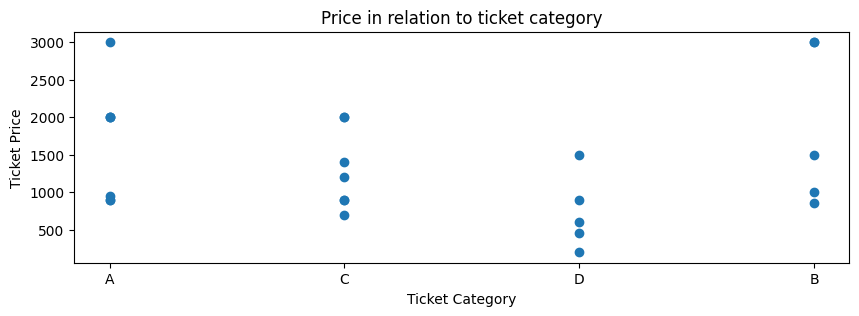

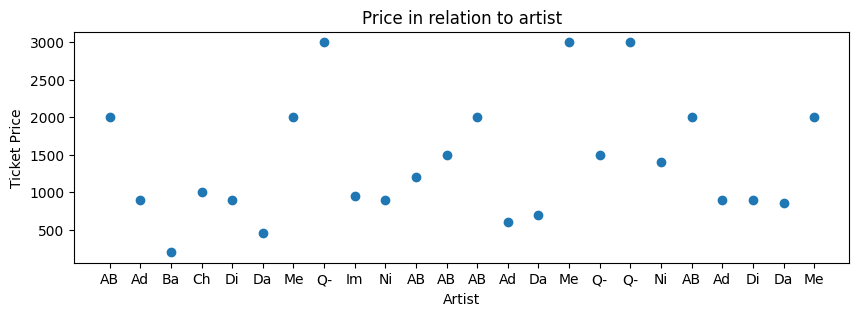

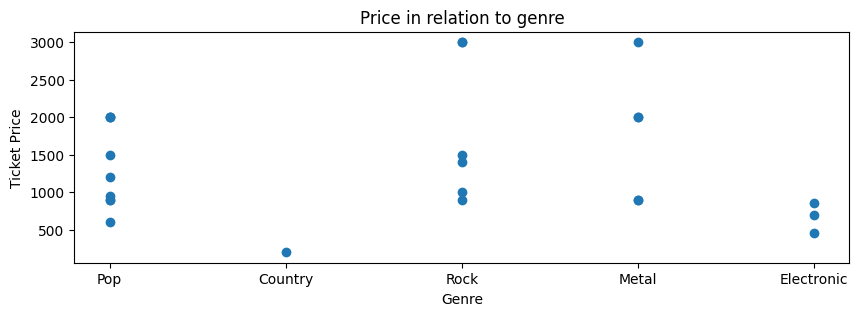

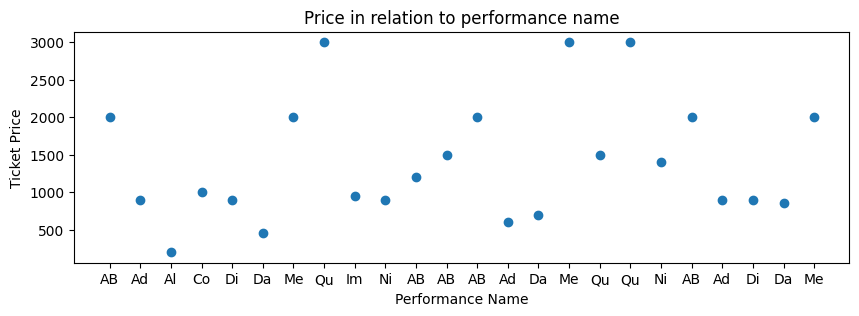

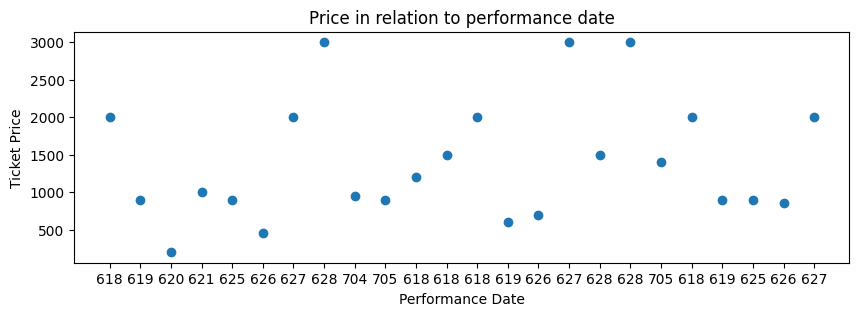

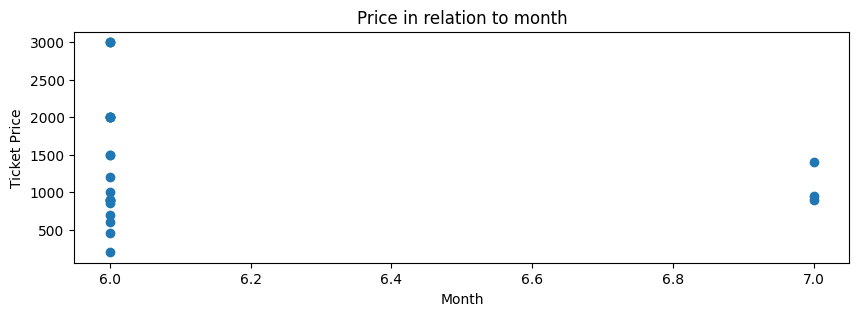

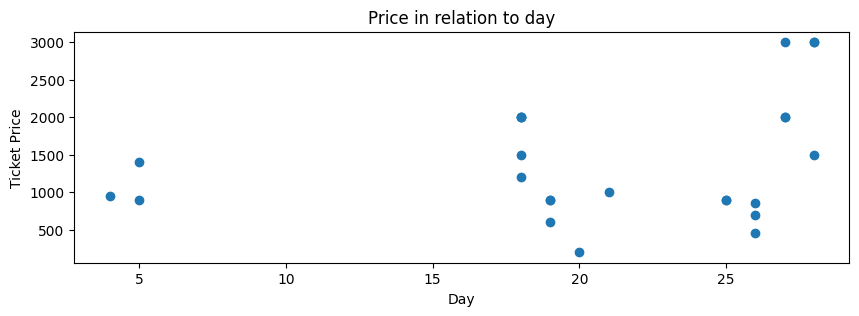

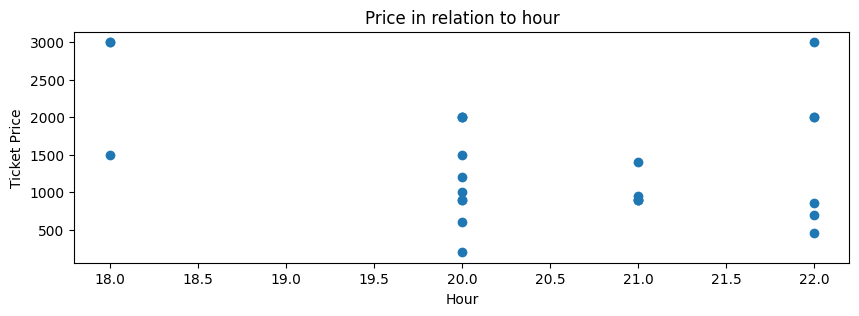

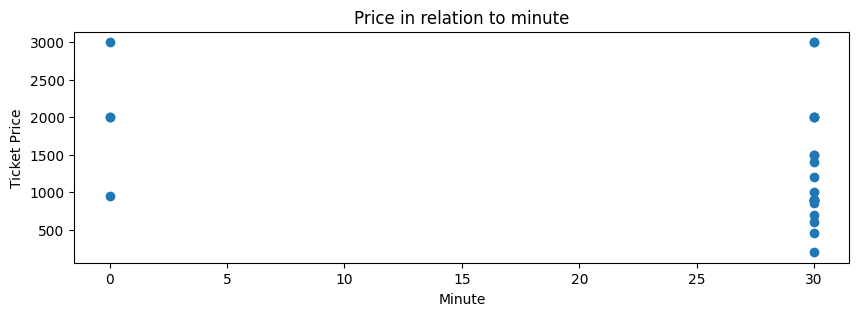

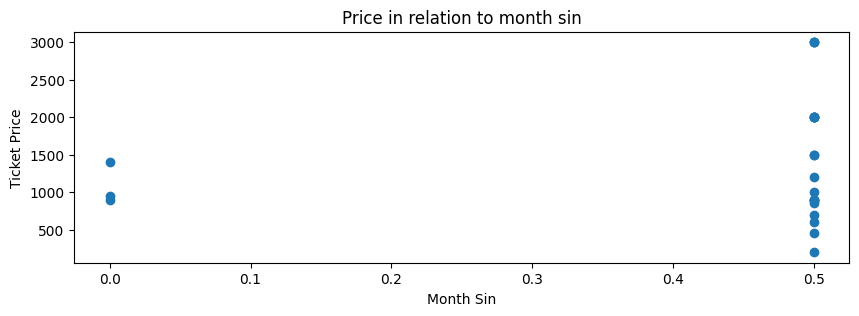

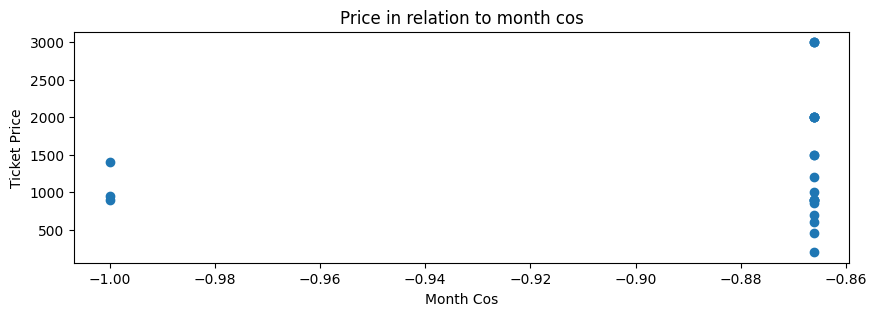

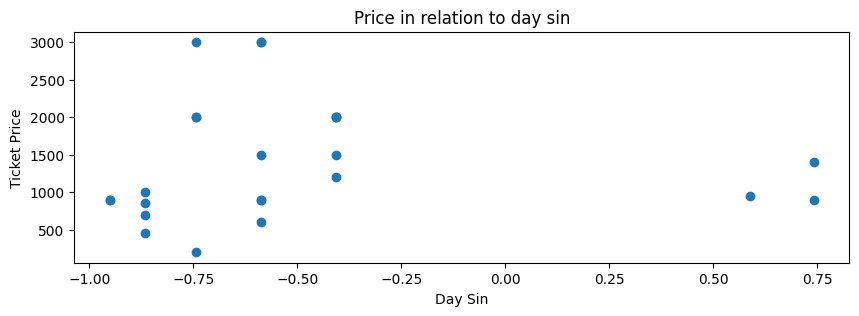

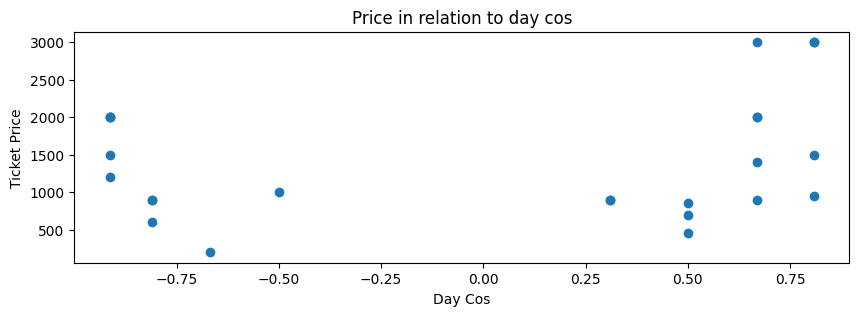

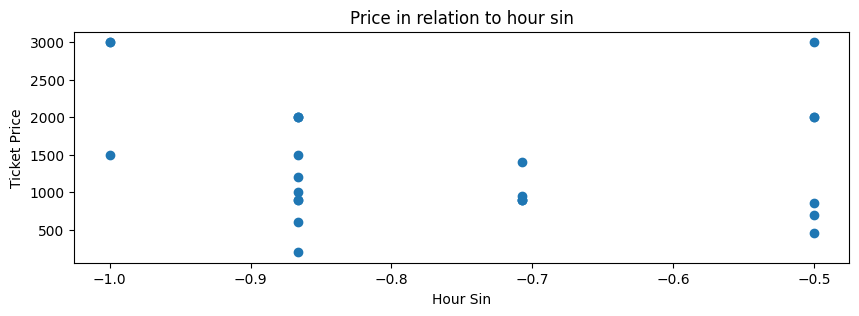

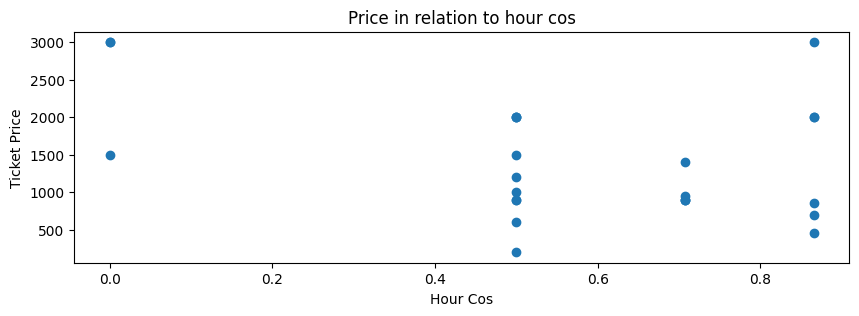

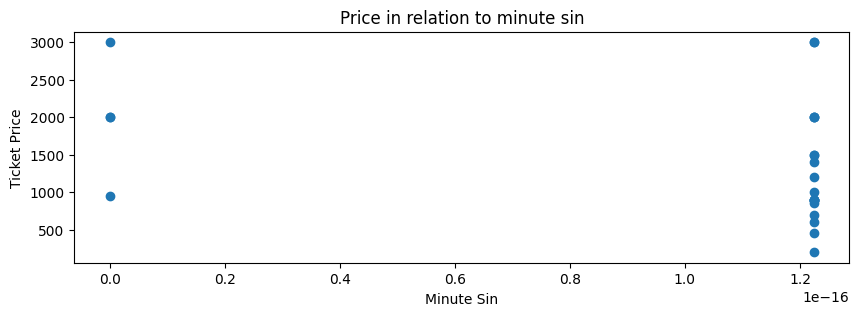

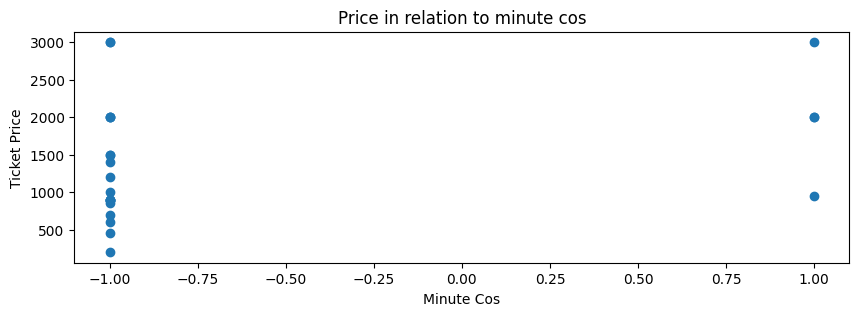

In [177]:
for column in X_train.columns:
    plt.figure(figsize=(10, 3))
    
    if column in ('Artist', 'Performance Name', 'Performance Date'):
        if column == 'Performance Date':
            short_labels = X_train[column].str[6:7] + X_train[column].str[8:10]
        else:
            short_labels = X_train[column].str[:2]
        
        x_positions = range(len(X_train[column]))
        
        plt.scatter(x_positions, y_train)
        plt.xticks(ticks=x_positions, labels=short_labels)
    else:
        plt.scatter(X_train[column], y_train)
    
    plt.title(f'Price in relation to {column.lower()}')
    plt.xlabel(f'{column}')
    plt.ylabel('Ticket Price')
    
    plt.show()

In [178]:
X_train_date_encd = X_train.drop(['Performance Date', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

In [181]:
# one-hot encoding for ticket category, artist, genre, performance name columns

categorical_cols = ['Ticket Category', 'Artist', 'Genre', 'Performance Name']

one_hot_enc = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
ohe_array = one_hot_enc.fit_transform(X_train[categorical_cols])

ohe_df = pd.DataFrame(
    ohe_array,
    columns=one_hot_enc.get_feature_names_out(categorical_cols),
    index=X_train.index
)

X_train_encoded = X_train_date_encd.drop(columns=categorical_cols)
X_train_encoded = pd.concat([X_train_encoded, ohe_df], axis=1)

X_train_encoded.head()

/Users/misha/Desktop/Concert_Price_Prediction/concert-price-prediction/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Month Sin,Month Cos,Day Sin,Day Cos,Hour Sin,Hour Cos,Minute Sin,Minute Cos,Ticket Category_B,Ticket Category_C,...,Genre_Rock,Performance Name_Adele,Performance Name_Alabama,Performance Name_Coldplay,Performance Name_Daft,Performance Name_Disturbed,Performance Name_Imagine,Performance Name_Metallica,Performance Name_Nirvana,Performance Name_Queen
0,0.5,-0.866025,-0.406737,-0.913545,-0.866025,0.500000,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,-0.866025,-0.587785,-0.809017,-0.866025,0.500000,1.224647e-16,-1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,-0.866025,-0.743145,-0.669131,-0.866025,0.500000,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,-0.866025,-0.866025,-0.500000,-0.866025,0.500000,1.224647e-16,-1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.5,-0.866025,-0.951057,0.309017,-0.707107,0.707107,1.224647e-16,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [185]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_train_encoded)
for i in range(len(y_train)):
    print(f'Actual: {y_train.iloc[i]}. Predicted: {y_pred[i]}')

Actual: 2000. Predicted: 2015.6105100463676
Actual: 900. Predicted: 958.0285076421094
Actual: 200. Predicted: 199.99999999999977
Actual: 1000. Predicted: 1000.0000000000007
Actual: 900. Predicted: 899.9999999999993
Actual: 450. Predicted: 190.12536493216544
Actual: 2000. Predicted: 2023.415765069551
Actual: 3000. Predicted: 2818.512794092392
Actual: 950. Predicted: 950.0000000000018
Actual: 900. Predicted: 912.9572385368383
Actual: 1200. Predicted: 1085.8578052550233
Actual: 1500. Predicted: 1567.310664605873
Actual: 2000. Predicted: 2015.6105100463676
Actual: 600. Predicted: 483.94298471578236
Actual: 700. Predicted: 664.2108878584925
Actual: 3000. Predicted: 2953.1684698608956
Actual: 1500. Predicted: 1862.9744118152153
Actual: 3000. Predicted: 2818.512794092392
Actual: 1400. Predicted: 1387.0427614631653
Actual: 2000. Predicted: 2015.6105100463676
Actual: 900. Predicted: 958.0285076421094
Actual: 900. Predicted: 899.9999999999993
Actual: 850. Predicted: 1145.663747209342
Actual: 200